In [144]:
import pandas as pd
import numpy as np
import networkx as nx

import pickle
import json

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(20, 11)}, font_scale=2)

from tqdm import tqdm
from sklearn.cluster import DBSCAN
from sklearn.neighbors import KernelDensity
from scipy.signal import find_peaks, peak_widths


# Import Custom packages
import sys
sys.path.append('../../')
import utils
import semantic_type_propagation as stp

# Functions

In [165]:
def get_vals_in_range(m, lower_bound=0, upper_bound=0.99):
    '''
    Given a numpy array `m`, return a list with all values in `m` that are within range specified by `lower_bound` and `upper_bound` 
    '''
    m_list = m.flatten().tolist()
    m_list = [val for val in m_list if  lower_bound < val < upper_bound]
    return m_list 


def get_epsilon(m, lower_bound=0, upper_bound=0.99, mode='greatest', bandwidth=0.03, num_samples=1000, rel_height=1):
    '''
    m is a distance matrix

    Whenever 'm_list' is empty return an epsilon of 1-`upper_bound`

    mode must be one of 'kde' or 'greatest' 
    '''
    m_list = get_vals_in_range(m, lower_bound=lower_bound, upper_bound=upper_bound)

    # Check if m_list is empty
    if len(m_list) == 0:
        return 1-upper_bound
    
    if mode == 'greatest':
        return max(m_list)
    elif mode == 'kde':
        density, samples = get_kde(m_list, bandwidth=bandwidth, num_samples=num_samples)
        widths = get_peak_widths(density, num_samples=num_samples, rel_height=rel_height)

        print(widths)
        return max(widths)
        

def get_kde(vals, bandwidth=0.03, num_samples=1000):
    '''
    Given a list of uniformly seperated values `vals` estimate density distribution using KDE

    Returns two lists, the density and the samples at which the density is estimated at
    '''

    # Compute the KDE curve
    points = np.array(np.array(vals)).reshape(-1,1)
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(points)
    samples = np.linspace(0,1, num=num_samples)
    density = np.exp(kde.score_samples(samples.reshape(-1,1)))

    return density, samples

def get_peak_widths(density, num_samples=1000, rel_height=0.5):
    # Find the indices of the peaks in the density distribution
    peaks, _ = find_peaks(density)

    # Find the widths of each peak with their respective locations and height
    widths, width_heights, left_ips, right_ips = peak_widths(density, peaks, rel_height=rel_height)

    # Convert the left_ips and right_ips from the sample space to the original space (0-1)
    widths = widths/num_samples
    x_mins = left_ips/num_samples
    x_maxs = right_ips/num_samples

    return widths  

# Jaccard Similarity

In [166]:
df_path = '../../output/synthetic_example_large/'
g_path = '../../../graph_construction/combined_graphs_output/synthetic_benchmark_large/bipartite/bipartite.graph'
input_nodes_json_path = '../../input/synthetic_large/input_nodes.json'
matrices_path = df_path + 'num_meanings/jaccard/matrices/'

df = pd.read_pickle(df_path + 'graph_stats_with_groundtruth_df.pickle')
G = pickle.load(open(g_path, "rb"))

with open(input_nodes_json_path) as f:
  input_nodes = json.load(f)['input_nodes']

# Remove nodes with degree 1 from the dataframe
df = stp.process_df(df, G)

# Compute the groundtruth for the number of meanings for each homograph
df = utils.num_meanings.get_num_meanings_groundtruth(df, G)
df_homs = df[df['is_homograph']==True].sort_values(by='betweenness_centrality', ascending=False)
df_homs

100%|██████████| 180/180 [00:00<00:00, 4631.35it/s]

There are 6502 cell nodes with a degree greater than 1
There are 611 unique ranks based on BC.


,node,node_type,betweenness_centrality,is_homograph,dense_rank,num_meanings_groundtruth
7590,Palm,cell,1.445700e-02,True,1.0,2
25825,Clementine,cell,8.975958e-03,True,2.0,2
7130,Magnolia,cell,8.132084e-03,True,3.0,2
3077,Jaguar,cell,8.049376e-03,True,4.0,2
7416,Timothy,cell,6.921700e-03,True,5.0,2
...,...,...,...,...,...,...
2000,MD,cell,2.103537e-07,True,275.0,2
1828,SD,cell,2.059766e-07,True,276.0,2
2004,ME,cell,1.214843e-07,True,314.0,2
1950,NC,cell,7.969017e-08,True,329.0,2


In [167]:
df_homs['num_meanings_groundtruth'].value_counts()

2    176
3      4
Name: num_meanings_groundtruth, dtype: int64

In [168]:
df_homs[df_homs['num_meanings_groundtruth'] > 2]

,node,node_type,betweenness_centrality,is_homograph,dense_rank,num_meanings_groundtruth
300,Lincoln,cell,0.004879,True,8.0,3
2012,Montana,cell,0.002381,True,15.0,3
1401,Aurora,cell,0.001690,True,20.0,3
546,Virginia,cell,0.001467,True,25.0,3


In [169]:
# Map each input node from tje json file to its pairwise distance matrix and its index to node dictionary
node_to_matrix_dict = {}
node_to_idx_dict = {}
for node in input_nodes:
    # We subtract the matrix from one to convert it from a similarity matrix to a distance matrix
    m = 1 - np.load(matrices_path + node + '.npy')
    idx_to_node = pickle.load(open(matrices_path + node + '_idx_to_node.pickle', 'rb'))

    node_to_matrix_dict[node] = m
    node_to_idx_dict[node] = idx_to_node

In [170]:
test_homograph = 'MA'
# m = np.load(matrices_path + test_homograph +'.npy')
# idx_to_node = pickle.load(open(matrices_path + test_homograph + '_idx_to_node.pickle', 'rb'))
print('Homograph:', test_homograph)
print('Distance Matrix:\n', node_to_matrix_dict[test_homograph])

print('Index to node dictionary:', node_to_idx_dict[test_homograph])
print('Column names that homograph is connected to:', utils.graph_helpers.get_cell_node_column_names(G, test_homograph))

labels = DBSCAN(min_samples=1, metric='precomputed', eps=0.5).fit_predict(node_to_matrix_dict[test_homograph])
print(labels)

Homograph: MA
Distance Matrix:
 [[0.         0.32885906 0.33561644 0.42307692 0.39354839 0.33333333
  0.3537415  0.36666667 0.91390728 0.93243243]
 [0.32885906 0.         0.32214765 0.36774194 0.4        0.38461538
  0.35099338 0.32       0.91082803 0.91447368]
 [0.33561644 0.32214765 0.         0.30821918 0.36601307 0.38157895
  0.34693878 0.37086093 0.90728477 0.92567568]
 [0.42307692 0.36774194 0.30821918 0.         0.35714286 0.38311688
  0.38157895 0.32885906 0.90196078 0.91275168]
 [0.39354839 0.4        0.36601307 0.35714286 0.         0.36363636
  0.35099338 0.35294118 0.90384615 0.92156863]
 [0.33333333 0.38461538 0.38157895 0.38311688 0.36363636 0.
  0.32191781 0.4        0.90849673 0.92666667]
 [0.3537415  0.35099338 0.34693878 0.38157895 0.35099338 0.32191781
  0.         0.37748344 0.89932886 0.91780822]
 [0.36666667 0.32       0.37086093 0.32885906 0.35294118 0.4
  0.37748344 0.         0.89403974 0.91946309]
 [0.91390728 0.91082803 0.90728477 0.90196078 0.90384615 0.9084

In [173]:
df['num_meanings'] = np.nan
df['epsilon'] = np.nan
homs_with_noise=0
num_non_trivial_predictions = 0

mode = 'kde'

# Loop over the input nodes and estimate the number of meanings 
for node in input_nodes:
    # Check number of attributes 'node' is connected to
    if len(utils.graph_helpers.get_attribute_of_instance(G, node)) > 2:
        m = node_to_matrix_dict[node]
        idx_to_node = node_to_idx_dict[node]

        epsilon = get_epsilon(m, lower_bound=0, upper_bound=0, mode='kde', bandwidth=0.03, num_samples=1000, rel_height=1)

        print(node)
        break

        # if mode == 'greatest':
        #     epsilon = get_epsilon(m)
        # elif mode == 'kde':
        #     sim_vals = get_vals_in_range(m, lower_bound=0, upper_bound=0.99)
        #     print(node, len(sim_vals))
        #     density, samples = get_kde(sim_vals, bandwidth=0.03, num_samples=1000)
        #     widths = get_peak_widths(density, num_samples=1000, rel_height=1)
        #     epsilon = max(widths)

        labels = DBSCAN(min_samples=1, metric='precomputed', eps=epsilon).fit_predict(m)

        if -1 in labels:
            homs_with_noise += 1

        num_meanings = len(set(labels))
        df.loc[df['node'] == node, 'num_meanings'] = num_meanings
        df.loc[df['node'] == node, 'epsilon'] = epsilon
        num_non_trivial_predictions+=1
    else:
        df.loc[df['node'] == node, 'num_meanings'] = 2

print("Number of homographs with noise:", homs_with_noise)
print("Number of non-trivial predictions:", num_non_trivial_predictions)
df['is_num_meanings_correct'] = df['num_meanings'] == df['num_meanings_groundtruth']
df[df['is_homograph']==True]

Palm
Number of homographs with noise: 0
Number of non-trivial predictions: 0


,node,node_type,betweenness_centrality,is_homograph,dense_rank,num_meanings_groundtruth,num_meanings,epsilon,is_num_meanings_correct
7590,Palm,cell,1.445700e-02,True,1.0,2,NaN,NaN,False
25825,Clementine,cell,8.975958e-03,True,2.0,2,NaN,NaN,False
7130,Magnolia,cell,8.132084e-03,True,3.0,2,NaN,NaN,False
3077,Jaguar,cell,8.049376e-03,True,4.0,2,NaN,NaN,False
7416,Timothy,cell,6.921700e-03,True,5.0,2,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...
2000,MD,cell,2.103537e-07,True,275.0,2,NaN,NaN,False
1828,SD,cell,2.059766e-07,True,276.0,2,NaN,NaN,False
2004,ME,cell,1.214843e-07,True,314.0,2,NaN,NaN,False
1950,NC,cell,7.969017e-08,True,329.0,2,NaN,NaN,False


In [161]:
df_homs = df[df['is_homograph']==True]
df_homs['is_num_meanings_correct'].value_counts()

False    102
True      78
Name: is_num_meanings_correct, dtype: int64

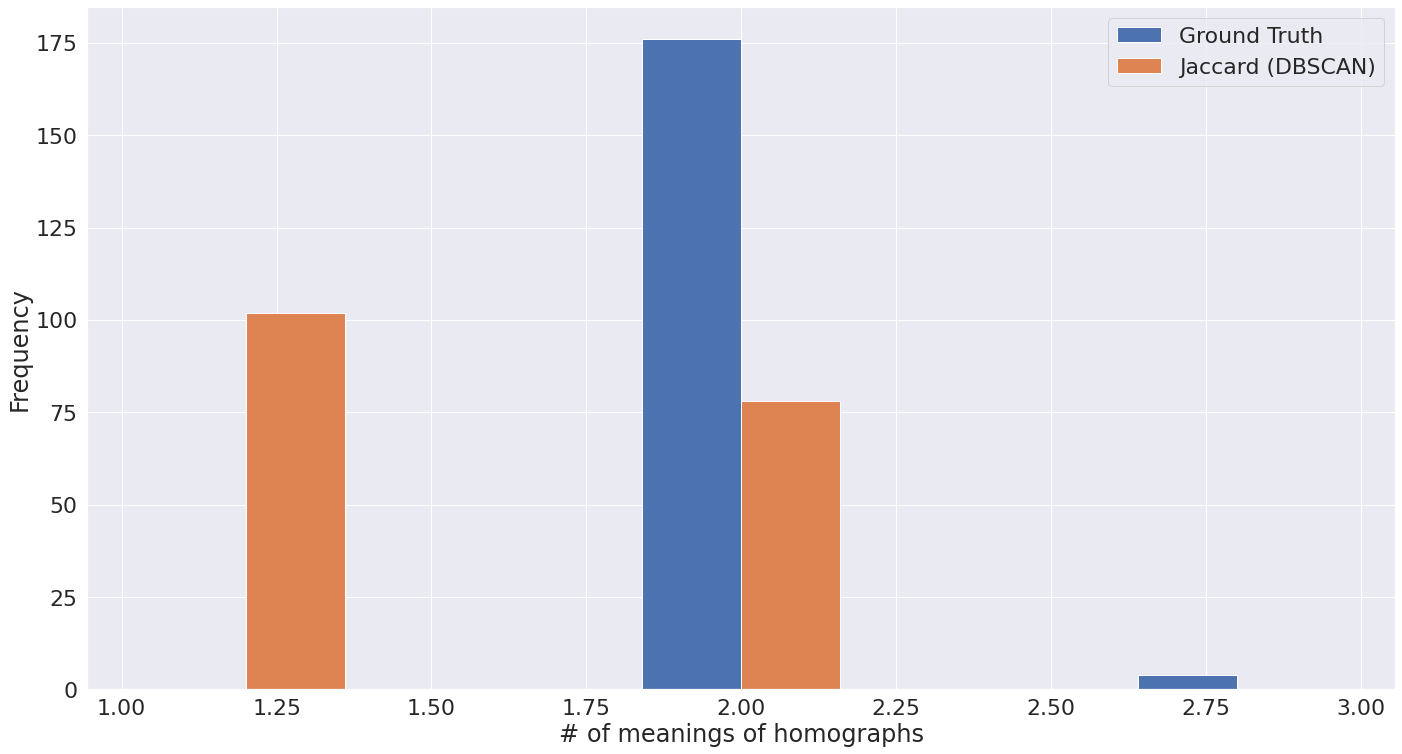

In [162]:
ax = plt.hist([df_homs['num_meanings_groundtruth'], df_homs['num_meanings']], bins=5, label=['Ground Truth', 'Jaccard (DBSCAN)'])
plt.xlabel('# of meanings of homographs');plt.ylabel('Frequency');plt.legend();plt.tight_layout()
# plt.savefig('../../figures/num_meanings/TUS/num_meanings_top_300_propagation_histogram.svg')

In [163]:
df_homs[df_homs['is_num_meanings_correct']==False]

,node,node_type,betweenness_centrality,is_homograph,dense_rank,num_meanings_groundtruth,num_meanings,epsilon,is_num_meanings_correct
7590,Palm,cell,1.445700e-02,True,1.0,2,1.0,1.0,False
25825,Clementine,cell,8.975958e-03,True,2.0,2,1.0,1.0,False
3077,Jaguar,cell,8.049376e-03,True,4.0,2,1.0,1.0,False
4078,Cougar,cell,5.781809e-03,True,6.0,2,1.0,1.0,False
300,Lincoln,cell,4.879061e-03,True,8.0,3,1.0,1.0,False
...,...,...,...,...,...,...,...,...,...
2000,MD,cell,2.103537e-07,True,275.0,2,1.0,1.0,False
1828,SD,cell,2.059766e-07,True,276.0,2,1.0,1.0,False
2004,ME,cell,1.214843e-07,True,314.0,2,1.0,1.0,False
1950,NC,cell,7.969017e-08,True,329.0,2,1.0,1.0,False


In [175]:
node_to_matrix_dict['Palm']

array([[0.        , 0.99947451, 0.99947562, 0.99947617],
       [0.99947451, 0.        , 0.97038234, 0.9704142 ],
       [0.99947562, 0.97038234, 0.        , 0.96770721],
       [0.99947617, 0.9704142 , 0.96770721, 0.        ]])

[0.00054097 0.00057279] [0.00915359 0.00955942] [0.96743651 0.97010886] [0.96797749 0.97068165]


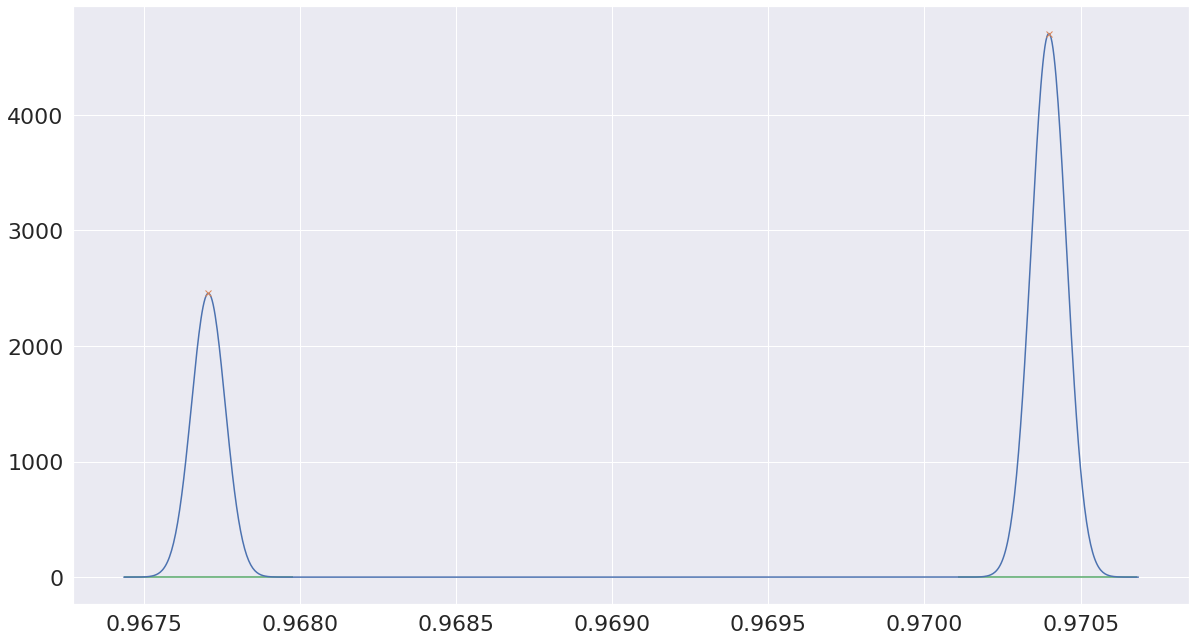

In [203]:
num_samples=1000
sim_vals = get_vals_in_range(node_to_matrix_dict['Palm'])

# Range of values
vals_range = max(sim_vals) - min(sim_vals)
samples_lower_bnd = min(sim_vals) - 0.10*vals_range
samples_higher_bnd = max(sim_vals) + 0.10*vals_range


points = np.array(np.array(sim_vals)).reshape(-1,1)
kde = KernelDensity(kernel='gaussian', bandwidth=(vals_range/num_samples)*20).fit(points)
samples = np.linspace(samples_lower_bnd, samples_higher_bnd, num=num_samples)
density = np.exp(kde.score_samples(samples.reshape(-1,1)))

# Get widths
peaks, _ = find_peaks(density)

# Find the widths of each peak with their respective locations and height
widths, width_heights, left_ips, right_ips = peak_widths(density, peaks, rel_height=1)

range_length = samples_higher_bnd - samples_lower_bnd
length_per_sample = range_length / num_samples

# Convert the left_ips and right_ips from the sample space to the original space (0-1)
widths = widths * length_per_sample
x_mins = (left_ips * length_per_sample) + samples_lower_bnd
x_maxs = (right_ips * length_per_sample) + samples_lower_bnd

print(widths, width_heights, x_mins, x_maxs)


plt.plot(samples, density)
plt.plot(samples[peaks], density[peaks], 'x')
plt.hlines(y=width_heights, xmin=x_mins, xmax=x_maxs, color="C2")

In [213]:
epsilon = max(widths)
labels = DBSCAN(min_samples=1, metric='precomputed', eps=0.98).fit_predict(node_to_matrix_dict['Palm'])
print(node_to_idx_dict['Palm'])
print(labels)

{0: 'first_name_personal_first_name_last_name_ssn_state_2.csv', 1: 'plant_name_nature_plant_name_scientific_name_family_2.csv', 2: 'plant_name_nature_plant_name_scientific_name_family_3.csv', 3: 'plant_name_nature_plant_name_scientific_name_family_country_3.csv'}
[0 1 1 1]


In [143]:
widths = get_peak_widths(density, num_samples=num_samples, rel_height=1)
print('Widths:', widths)

# Set epsilon to the maximum peak width obtained
epsilon = max(widths)

labels = DBSCAN(min_samples=1, metric='precomputed', eps=0.36).fit_predict(node_to_matrix_dict['AZ'])
print(node_to_idx_dict['AZ'])
print(labels)

Widths: [0.59152885 0.17348371]
{0: 'country_code_location_country_country_code_1.csv', 1: 'country_code_location_country_country_code_2.csv', 2: 'country_code_product_car_make_car_model_car_model_year_country_code_1.csv', 3: 'country_code_product_car_make_car_model_car_model_year_country_code_2.csv', 4: 'country_code_product_car_make_car_model_car_model_year_country_code_3.csv', 5: 'country_code_product_movie_title_movie_genre_country_code_1.csv', 6: 'country_code_product_movie_title_movie_genre_country_code_2.csv', 7: 'country_code_product_movie_title_movie_genre_country_code_3.csv', 8: 'state_abbrev_location_state_state_abbrev_1.csv', 9: 'state_abbrev_location_state_state_abbrev_2.csv'}
[0 0 0 0 0 0 0 0 1 1]


[358 912]
[0.25034081 0.16526907] [0.05955068 0.14820708] [0.23282197 0.82962361] [0.48316277 0.99489268]


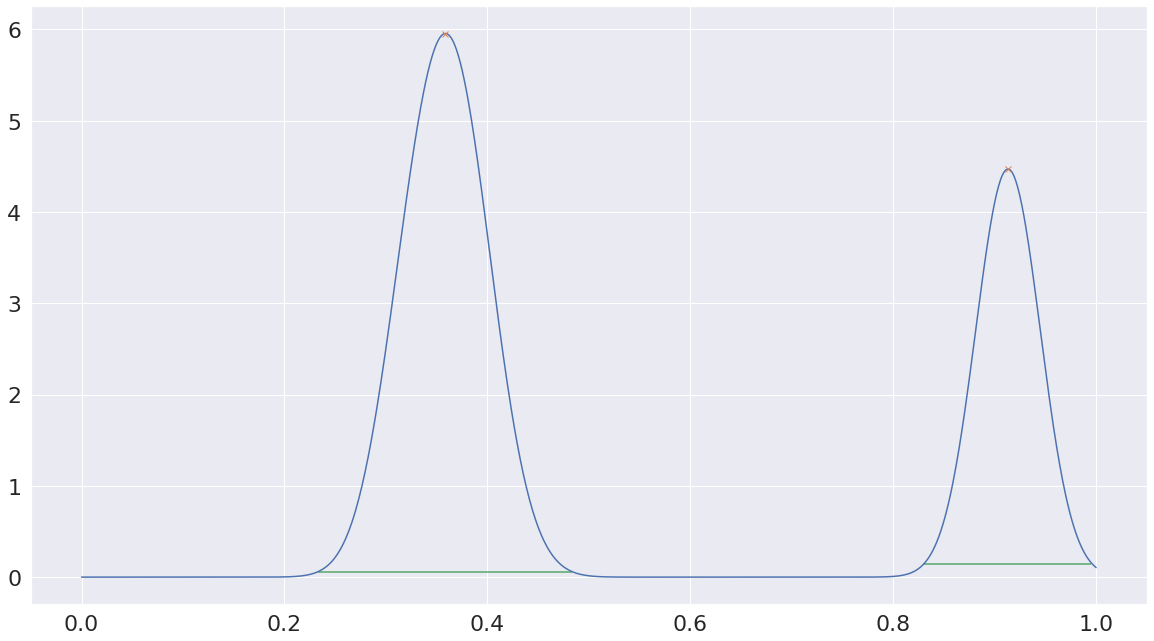

In [142]:
peaks, prop_dict = find_peaks(density)
widths, width_heights, left_ips, right_ips = peak_widths(density, peaks, rel_height=0.99)

# Convert the left_ips and right_ips from the sample space to the original space (0-1)
widths = widths/num_samples
x_mins = left_ips/num_samples
x_maxs = right_ips/num_samples

print(peaks)
print(widths, width_heights, x_mins, x_maxs)
# print(*results_half[1:])

plt.plot(samples, density)
plt.plot(samples[peaks], density[peaks], 'x')
plt.hlines(y=width_heights, xmin=x_mins, xmax=x_maxs, color="C2")
# print(samples[peaks])